# GENERADOR DE DATASET- GASTOS PERSONALES

Como es de conocimeinto publico los datos de ingresos y gastos de una persona son información sensible y a falta de un dataset completo de gastos e ingresos de una persona se desarrolla este proyecto para las practicas de ciencia de datos.

## PASO 1: Generar proyección del Historial de remuneracion minima vital 
 
 trabajamos esta fuente primero
 **historial_salario_minimo.csv**

fuente (BCR): https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PN02124PM/html/1970-1/2025-9/

In [1]:
# Instalación de librerías necesarias
%pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
import os

In [4]:
# --- 1. Cargar el archivo y configurar ---

# Nombre de los archivos
archivo_entrada = 'historial_salario_minimo.csv'
archivo_salida = 'proyeccion_salario_minimo.csv'

In [8]:
# Ruta absoluta del directorio donde se encuentra este script/notebook
directorio_actual = os.getcwd()

In [9]:
# Ruta completa del archivo de entrada
ruta_entrada = os.path.join(directorio_actual, archivo_entrada)

In [10]:
try:
    df = pd.read_csv(ruta_entrada)
except FileNotFoundError:
    print(f"Error: El archivo '{archivo_entrada}' no se encontró en el directorio: {directorio_actual}")
    exit()

In [11]:
# =========================================================================
# 2. Preprocesamiento y Creación de la Serie Temporal
# =========================================================================

# Función para convertir 'Ene91' a '1991-01-01'
def parse_date(date_str):
    mes = date_str[:3]
    anio = date_str[3:]
    meses_map = {
        'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Ago': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12
    }
    if len(anio) == 2:
        if int(anio) > 50:
            anio = '19' + anio
        else:
            anio = '20' + anio
    return datetime(int(anio), meses_map[mes], 1)

# Aplicar la función de conversión de fecha
df['Fecha_dt'] = df['Fecha'].apply(parse_date)
fecha_inicio = df['Fecha_dt'].min()

# Calcular el índice temporal (X para el modelo)
df['Mes_Index'] = (df['Fecha_dt'].dt.to_period('M') - fecha_inicio.to_period('M')).apply(lambda x: x.n)
df['Salario_minimo'] = pd.to_numeric(df['Salario_minimo'], errors='coerce')

# *** ACOTACIÓN 1: Guardar el valor histórico real ***
df['Salario_minimo_historial'] = df['Salario_minimo'].copy()

In [17]:
# =========================================================================
# 3. Entrenamiento del Modelo (Regresión Polinomial de Grado 2)
# =========================================================================
X_train = df[['Mes_Index']].values
y_train = df['Salario_minimo'].values

poly_features = PolynomialFeatures(degree=2)
X_poly_train = poly_features.fit_transform(X_train)

model = LinearRegression()
model.fit(X_poly_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [18]:
# =========================================================================
# 4. Preparación y Realización de la Proyección
# =========================================================================
ultimo_indice = df['Mes_Index'].max()
fecha_fin_proyeccion = datetime(2035, 12, 1) # Proyectar hasta Dic-2035
indice_fin_proyeccion = (pd.Timestamp(fecha_fin_proyeccion).to_period('M') - fecha_inicio.to_period('M')).n

indices_proyeccion = np.arange(0, indice_fin_proyeccion + 1).reshape(-1, 1)

X_proyeccion = poly_features.transform(indices_proyeccion)
proyecciones = model.predict(X_proyeccion)

In [19]:
# =========================================================================
# 5. Creación del DataFrame de Proyección e Implementación de la Lógica RMV
# =========================================================================

df_proyeccion = pd.DataFrame()
df_proyeccion['Mes_Index'] = indices_proyeccion.flatten()
df_proyeccion['Fecha_dt'] = df_proyeccion['Mes_Index'].apply(
    lambda i: fecha_inicio + pd.DateOffset(months=i)
)
df_proyeccion['Salario_minimo_proyectado_continuo'] = np.maximum(proyecciones, df['Salario_minimo'].min()).round(2)


# --- LÓGICA DE APLICACIÓN DE RMV REALISTA (RESPETAR HISTORIAL Y CAMBIO ANUAL) ---

# 1. Asignar los valores históricos reales
df_proyeccion['Salario_minimo'] = df_proyeccion['Salario_minimo_proyectado_continuo']
df_proyeccion.loc[df_proyeccion['Mes_Index'] <= ultimo_indice, 'Salario_minimo'] = df['Salario_minimo_historial'].values

# Obtener el último valor histórico real (S/ 1130.0 para Dic-2025)
# Esto servirá como el umbral mínimo para todas las proyecciones futuras.
ULTIMO_RMV_HISTORICO = df['Salario_minimo_historial'].iloc[-1] 

# 2. Simular el comportamiento de RMV por períodos (cambio anual)
df_futuro = df_proyeccion[df_proyeccion['Mes_Index'] > ultimo_indice].copy()
df_futuro['Anio'] = df_futuro['Fecha_dt'].dt.year

# Calcular el valor del salario proyectado para Enero de cada año futuro
rmv_anual_proyectada_continua = df_futuro[df_futuro['Fecha_dt'].dt.month == 1].set_index('Anio')['Salario_minimo_proyectado_continuo']

# *** IMPLEMENTACIÓN DE LA ACOTACIÓN: La RMV nunca decrece ***
# La RMV proyectada para Enero debe ser el máximo entre:
# 1. El valor proyectado por el modelo.
# 2. El último valor histórico real conocido.

rmv_anual_ajustada = {}
# El primer valor (Jan-2026) se compara con el último histórico (Dic-2025)
rmv_anterior = ULTIMO_RMV_HISTORICO

for anio, rmv_proyectada in rmv_anual_proyectada_continua.items():
    
    # Restricción 1: El nuevo valor debe ser mayor o igual al valor del año anterior (escalón)
    nuevo_rmv = max(rmv_proyectada, rmv_anterior)
    
    # Redondeamos al múltiplo de 1 o 10 más cercano (ej. 1150.0 o 1151.0), por realismo
    nuevo_rmv_redondeado = round(nuevo_rmv / 10.0) * 10.0 if (nuevo_rmv > 500) else round(nuevo_rmv)
    
    # Aseguramos que el valor no sea menor al valor anterior después del redondeo
    final_rmv = max(nuevo_rmv_redondeado, rmv_anterior)
    
    rmv_anual_ajustada[anio] = final_rmv
    rmv_anterior = final_rmv # Actualizar el valor anterior para la siguiente iteración


# Aplicar el valor de Enero a todos los meses de ese año (comportamiento de escalón)
df_futuro['Salario_minimo_ajustado'] = df_futuro['Anio'].map(rmv_anual_ajustada)

# Reemplazar los valores de proyección continua por los ajustados
df_proyeccion.loc[df_proyeccion['Mes_Index'] > ultimo_indice, 'Salario_minimo'] = df_futuro['Salario_minimo_ajustado'].values


# --- Preparación para la Exportación ---

# Formatear la columna 'Fecha' como 'Ene91', 'Feb91', etc.
def format_date_output(dt):
    mes_abr = dt.strftime('%b')[:3]
    anio_dos_digitos = dt.strftime('%y')
    return f"{mes_abr.capitalize()}{anio_dos_digitos}"

df_proyeccion['Fecha'] = df_proyeccion['Fecha_dt'].apply(format_date_output)

# Determinar si el valor es un historial o una proyección
df_proyeccion['Tipo_de_valor'] = np.where(
    df_proyeccion['Mes_Index'] <= ultimo_indice, 
    'Historial', 
    'Proyección'
)

# Filtrar para obtener solo las columnas deseadas para la exportación
df_final = df_proyeccion[['Fecha', 'Salario_minimo', 'Tipo_de_valor']]

# Guardar el nuevo archivo CSV
ruta_salida = os.path.join(directorio_actual, archivo_salida)
df_final.to_csv(ruta_salida, index=False)

print(f"✅ ¡Proceso completado!")
print(f"Se ha creado el archivo de proyección: {archivo_salida}")
print(f"Ubicación: {ruta_salida}")
print("\n--- Vista previa de los datos proyectados (últimas filas) ---")
print(df_final[df_final['Tipo_de_valor'] == 'Proyección'].tail())

✅ ¡Proceso completado!
Se ha creado el archivo de proyección: proyeccion_salario_minimo.csv
Ubicación: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/proyeccion_salario_minimo.csv

--- Vista previa de los datos proyectados (últimas filas) ---
     Fecha  Salario_minimo Tipo_de_valor
535  Aug35          1370.0    Proyección
536  Sep35          1370.0    Proyección
537  Oct35          1370.0    Proyección
538  Nov35          1370.0    Proyección
539  Dec35          1370.0    Proyección



--- Generando Gráfica de Proyección ---


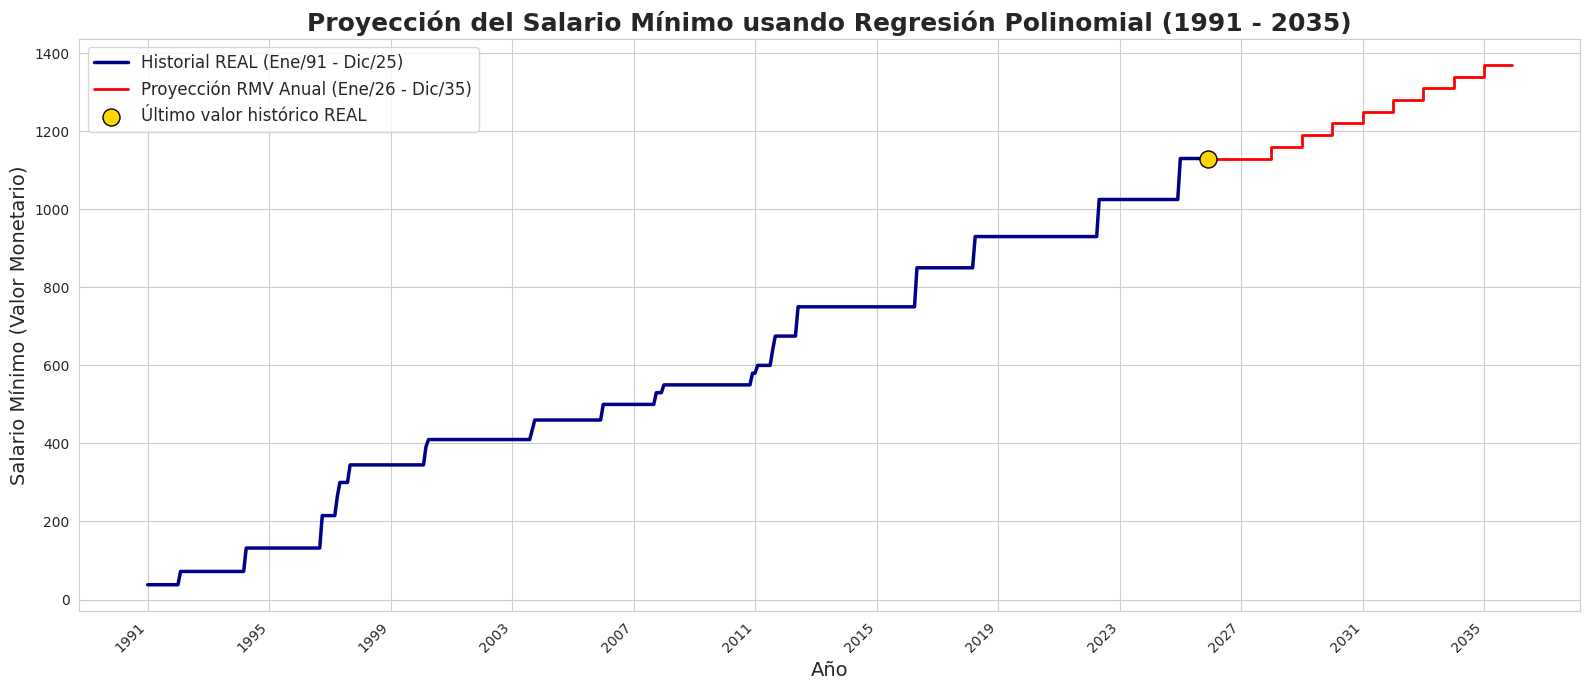

Se ha guardado la gráfica en: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/proyeccion_salario_minimo.png


In [20]:
# =========================================================================
# 6. Visualización de los Resultados
# =========================================================================

print("\n--- Generando Gráfica de Proyección ---")

# Convertir la columna de fecha a formato numérico (para el eje X)
df_final = df_proyeccion[['Fecha_dt', 'Fecha', 'Salario_minimo', 'Tipo_de_valor']]

# Definir los datos históricos y de proyección
df_historial = df_final[df_final['Tipo_de_valor'] == 'Historial']
df_proyeccion_final = df_final[df_final['Tipo_de_valor'] == 'Proyección']
df_punto_corte = df_final.iloc[df_historial.index[-1]]

# Configuración de la gráfica
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# 1. Graficar la data histórica (línea sólida)
plt.plot(
    df_historial['Fecha_dt'], 
    df_historial['Salario_minimo'], 
    label='Historial REAL (Ene/91 - Dic/25)', 
    color='darkblue', 
    linewidth=2.5
)

# 2. Graficar la data proyectada (línea punteada con escalones)
plt.plot(
    df_proyeccion_final['Fecha_dt'], 
    df_proyeccion_final['Salario_minimo'], 
    label='Proyección RMV Anual (Ene/26 - Dic/35)', 
    color='red', 
    linestyle='-', 
    drawstyle='steps-post', # <-- Usa 'steps-post' para el efecto de escalón
    linewidth=2
)


# 3. Marcar el punto de corte
plt.scatter(
    df_punto_corte['Fecha_dt'], 
    df_punto_corte['Salario_minimo'], 
    color='gold', 
    edgecolor='black', 
    s=150, 
    zorder=5, 
    label='Último valor histórico REAL'
)

# 4. Añadir Títulos y Etiquetas
plt.title('Proyección del Salario Mínimo usando Regresión Polinomial (1991 - 2035)', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Salario Mínimo (Valor Monetario)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 5. Formato del Eje X (Mostrar solo una selección de años para claridad)
fechas_ticks = pd.to_datetime([f'{y}-01-01' for y in range(1991, 2036, 4)])
plt.gca().set_xticks(fechas_ticks)
plt.gca().set_xticklabels([f.strftime('%Y') for f in fechas_ticks])


# 6. Guardar y Mostrar la gráfica
plt.tight_layout()
ruta_grafica = os.path.join(directorio_actual, 'proyeccion_salario_minimo.png')
plt.savefig(ruta_grafica)
plt.show()

print(f"Se ha guardado la gráfica en: {ruta_grafica}")

## PASO 2: Generar proyección del Historial de Inflacion en Peru 
 
 trabajamos desde esta fuente:
 **inflacion_Peru_BCR.csv**

fuente (Banco Central de Reserva del Perú): https://estadisticas.bcrp.gob.pe/estadisticas/series/anuales/resultados/PM05197PA/html

Nota : Modificaremos el dataset **inflacion_Peru_BCR.csv** añadiendolas dos ultimas proyecciones del bcr sobre la inflacion 
fuente : diapositiva 35 del informe https://www.bcrp.gob.pe/docs/Publicaciones/Reporte-Inflacion/2025/setiembre/reporte-de-inflacion-setiembre-2025-presentacion.pdf


In [21]:
# --- 1. Cargar el archivo y configurar ---

# Nombres de los archivos
archivo_entrada = 'inflacion_Peru_BCR.csv'
archivo_salida = 'proyeccion_inflacion_BCR_lineal_v3.csv' # Versión actualizada
ANIO_INICIO_FILTRO = 1997 

# Rutas
directorio_actual = os.getcwd()
ruta_entrada = os.path.join(directorio_actual, archivo_entrada)

try:
    # Si la primera fila es un encabezado vacío, usamos header=1 para tomar la segunda línea.
    df = pd.read_csv(ruta_entrada, header=1) 
except FileNotFoundError:
    print(f"Error: El archivo '{archivo_entrada}' no se encontró en el directorio: {directorio_actual}")
    exit()

In [33]:
# --- 2. Preprocesamiento y Creación de la Serie Temporal ---

# PASO DE CORRECCIÓN 1: Limpiar espacios en blanco de los nombres de columna
df.columns = df.columns.str.strip()

# PASO DE CORRECCIÓN 2: Asignar directamente los nombres de columna esperados
try:
    df.columns = ['Anio', 'Inflacion_anual'] 
except ValueError:
    print("Error al asignar nombres de columna: El archivo no tiene las 2 columnas esperadas.")
    print("Columnas detectadas:", df.columns.tolist())
    exit()

# Limpiar y convertir la columna de inflación a numérica
# Reemplazar 'n.d.' con NaN y luego convertir a float
df['Inflacion_anual'] = df['Inflacion_anual'].replace(['n.d.', ' '], np.nan)
df['Inflacion_anual'] = pd.to_numeric(df['Inflacion_anual'], errors='coerce')

# Convertir la columna de Año a entero
df['Anio'] = pd.to_numeric(df['Anio'], errors='coerce').astype('Int64')

# Eliminar filas con valores faltantes en las columnas clave
df = df.dropna(subset=['Anio', 'Inflacion_anual']) 

# Filtramos la data para empezar desde ANIO_INICIO_FILTRO (e.g., 1997)
df_filtrado = df[df['Anio'] >= ANIO_INICIO_FILTRO].copy()

# Calcular el índice del año (X para el modelo)
anio_inicio = df_filtrado['Anio'].min()
df_filtrado['Anio_Index'] = df_filtrado['Anio'] - anio_inicio
df_filtrado['Fecha_dt'] = pd.to_datetime(df_filtrado['Anio'].astype(str) + '-01-01')

In [34]:
# --- 3. Entrenamiento del Modelo (Regresión Polinomial) ---

X_train = df_filtrado[['Anio_Index']].values
y_train = df_filtrado['Inflacion_anual'].values

# Usar Regresión Polinomial de Grado 2 para mejor ajuste
grado_polinomial = 2 
poly_features = PolynomialFeatures(degree=grado_polinomial)
X_poly_train = poly_features.fit_transform(X_train)

# Entrenar el modelo de Regresión Lineal sobre las features polinomiales
model = LinearRegression()
model.fit(X_poly_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [35]:
# --- 4. Preparación de la Proyección (hasta 2035) ---

ultimo_anio = df_filtrado['Anio'].max()
ultimo_indice = df_filtrado['Anio_Index'].max()
# MÁXIMO HISTÓRICO: Se usa para acotar el ruido de la proyección
max_inflacion_historica = df_filtrado['Inflacion_anual'].max()

anio_fin_proyeccion = 2035
indice_fin_proyeccion = anio_fin_proyeccion - anio_inicio

# Crear una serie de índices de años para la proyección
indices_proyeccion = np.arange(0, indice_fin_proyeccion + 1).reshape(-1, 1)

# Transformar los índices para el modelo polinomial
X_poly_proyeccion = poly_features.transform(indices_proyeccion)

# Realizar la proyección
proyecciones = model.predict(X_poly_proyeccion)

In [36]:
# --- 5. Creación del DataFrame de Proyección y Exportación (CORREGIDO) ---

df_proyeccion = pd.DataFrame()
df_proyeccion['Anio_Index'] = indices_proyeccion.flatten()
df_proyeccion['Anio'] = df_proyeccion['Anio_Index'] + anio_inicio
df_proyeccion['Fecha_dt'] = pd.to_datetime(df_proyeccion['Anio'].astype(str) + '-01-01')

# Asignar la inflación proyectada continua
min_inflacion = 1.0 
proyecciones_continuas = np.maximum(proyecciones, min_inflacion).round(2) 

# *** SOLUCIÓN AL ERROR: Definir historial_map antes de usarlo ***
historial_map = df_filtrado.set_index('Anio')['Inflacion_anual'].to_dict()
# --------------------------------------------------------------------------
# *** IMPLEMENTACIÓN DEL RUIDO Y ACOTAMIENTO ***
# --------------------------------------------------------------------------

# Coeficientes para el ruido: 
escala_ruido = 0.5 
# Máximo acotado (Asegura que el tope sea el máximo histórico o 5.0%, el que sea mayor)
max_acotado = np.maximum(max_inflacion_historica, 5.0) 

inflacion_ajustada = []

for idx, anio in enumerate(df_proyeccion['Anio']):
    
    if anio <= ultimo_anio:
        # **Usar valor histórico real (fidelidad)**
        valor_final = historial_map.get(anio) 
    else:
        # **Aplicar Regresión Polinomial y Ruido Acotado (realismo)**
        proyeccion_modelo = proyecciones_continuas[idx]
        
        # Generar ruido aleatorio (ej. entre -0.5 y 0.5)
        ruido = np.random.uniform(-escala_ruido, escala_ruido)
        
        # Aplicar el ruido a la proyección del modelo
        valor_con_ruido = proyeccion_modelo + ruido
        
        # Aplicar el acotamiento: [1.0%, Max_Acotado]
        valor_final = np.clip(valor_con_ruido, min_inflacion, max_acotado)
        
        # Redondear el valor final
        valor_final = round(valor_final, 2)
        
    inflacion_ajustada.append(valor_final)

df_proyeccion['Inflacion_anual'] = inflacion_ajustada
df_proyeccion['Tipo_de_valor'] = np.where(
    df_proyeccion['Anio'] <= ultimo_anio, 
    'Historial', 
    'Proyección'
)

# --------------------------------------------------------------------------

df_final = df_proyeccion[['Fecha_dt', 'Anio', 'Inflacion_anual', 'Tipo_de_valor']]

# Guardar el nuevo archivo CSV
ruta_salida = os.path.join(directorio_actual, archivo_salida)
df_final[['Anio', 'Inflacion_anual', 'Tipo_de_valor']].to_csv(ruta_salida, index=False)

print(f"✅ ¡Proceso de datos de inflación completado con Polinomial (Grado {grado_polinomial}) y Ruido Acotado!")
print(f"Se ha creado el archivo de proyección: {archivo_salida}")
print("\n--- Vista previa de los datos proyectados (últimas filas) ---")
print(df_final[df_final['Tipo_de_valor'] == 'Proyección'].tail())

✅ ¡Proceso de datos de inflación completado con Polinomial (Grado 2) y Ruido Acotado!
Se ha creado el archivo de proyección: proyeccion_inflacion_BCR_lineal_v3.csv

--- Vista previa de los datos proyectados (últimas filas) ---
     Fecha_dt  Anio  Inflacion_anual Tipo_de_valor
34 2031-01-01  2031             4.57    Proyección
35 2032-01-01  2032             4.98    Proyección
36 2033-01-01  2033             5.07    Proyección
37 2034-01-01  2034             4.95    Proyección
38 2035-01-01  2035             5.60    Proyección



--- Generando Gráfica de Proyección de Inflación ---


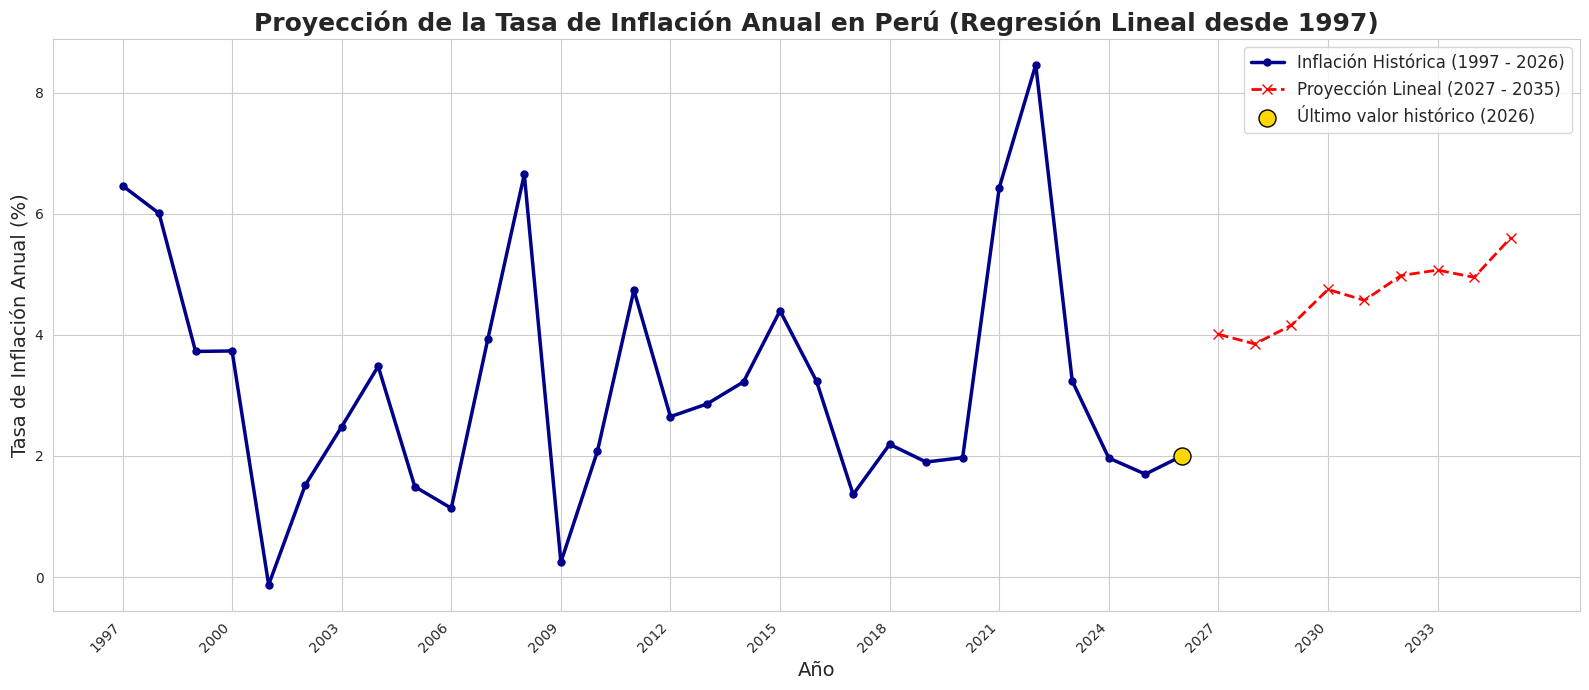

Se ha guardado la gráfica en: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/proyeccion_inflacion_BCR_lineal.png


In [37]:
# --- 6. Visualización de los Resultados ---

print("\n--- Generando Gráfica de Proyección de Inflación ---")

# Datos para graficar
df_historial = df_final[df_final['Tipo_de_valor'] == 'Historial']
df_proyeccion = df_final[df_final['Tipo_de_valor'] == 'Proyección']

df_punto_corte = df_historial.iloc[-1]

# Configuración de la gráfica
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# 1. Graficar la data histórica (línea sólida)
plt.plot(
    df_historial['Fecha_dt'], 
    df_historial['Inflacion_anual'], 
    label=f'Inflación Histórica ({anio_inicio} - {ultimo_anio})', 
    color='darkblue', 
    linewidth=2.5,
    marker='o',
    markersize=5
)

# 2. Graficar la data proyectada (línea punteada)
plt.plot(
    df_proyeccion['Fecha_dt'], 
    df_proyeccion['Inflacion_anual'], 
    label=f'Proyección Lineal ({ultimo_anio + 1} - 2035)', 
    color='red', 
    linestyle='--', 
    linewidth=2,
    marker='x',
    markersize=7
)

# 3. Marcar el punto de corte
plt.scatter(
    df_punto_corte['Fecha_dt'], 
    df_punto_corte['Inflacion_anual'], 
    color='gold', 
    edgecolor='black', 
    s=150, 
    zorder=5, 
    label=f'Último valor histórico ({ultimo_anio})'
)

# 4. Añadir Títulos y Etiquetas
plt.title(f'Proyección de la Tasa de Inflación Anual en Perú (Regresión Lineal desde {anio_inicio})', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Tasa de Inflación Anual (%)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 5. Formato del Eje X 
min_anio_grafica = df_final['Anio'].min()
max_anio_grafica = df_final['Anio'].max()
fechas_ticks = pd.to_datetime([f'{y}-01-01' for y in range(min_anio_grafica, max_anio_grafica + 1, 3)]) # Marcadores cada 3 años
plt.gca().set_xticks(fechas_ticks)
plt.gca().set_xticklabels([f.strftime('%Y') for f in fechas_ticks])

# 6. Guardar y Mostrar la gráfica
plt.tight_layout()
ruta_grafica = os.path.join(directorio_actual, 'proyeccion_inflacion_BCR_lineal.png')
plt.savefig(ruta_grafica)
plt.show()

print(f"Se ha guardado la gráfica en: {ruta_grafica}")

## PASO 3:  Extracción de Datos y Definición de la Estructura de Gasto (Perú) 
 
 Para generar el dataset sintético de gastos e ingresos, primero necesitamos definir la estructura de gasto promedio de un hogar o persona en Perú. Hemos consultado las referencias provistas (INEI, CEPLAN, reportes de consumo) y realizaremos una búsqueda para obtener la distribución porcentual más reciente y precisa del gasto.

 ### Estructura de Gasto Promedio en Perú (Datos Extraídos)

 Según el Reporte Perfil Económico y Hábitos de Consumo del Peruano Promedio y la Estructura de Gasto del INEI (usando datos de la ENAPRES/ENH que analiza CEPLAN), la distribución del gasto de un hogar en Perú se concentra fuertemente en necesidades básicas.

Utilizaremos la siguiente estructura porcentual de gasto mensual (ajustada para reflejar los principales rubros de un individuo con ingresos limitados):

fuentes: 
https://www.datosabiertos.gob.pe/dataset/encuesta-nacional-de-hogares-enaho-2022-instituto-nacional-de-estad%C3%ADstica-e-inform%C3%A1tica-%E2%80%93

https://www.gob.pe/institucion/inei/campa%C3%B1as/8600-encuesta-nacional-de-hogares-enaho-2023

https://www.inegi.org.mx/rnm/index.php/catalog/1116

https://www.ine.es/infografias/gastosepf/desktop/gastos.html?t=0&lang=es

https://n26.com/es-es/financial-wellness-index

https://capital.es/economia/espanoles-60-vivienda-hipoteca/89522/

https://www.inegi.org.mx/programas/enigh/nc/2024/

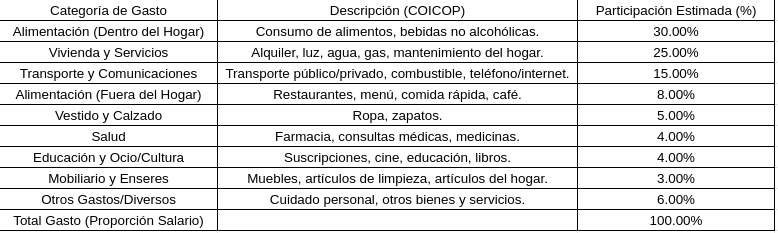

### Configuración de Datos Base

Carga las proyecciones de salario e inflación, establece los parámetros de simulación y define la estructura de gasto que se utilizará para la generación de la data.

In [26]:
# =========================================================================
# 3. EXTRACCIÓN Y CONFIGURACIÓN DE PARÁMETROS DE SIMULACIÓN
# =========================================================================

# --- 3.1. Definición de Parámetros de Simulación ---

# Parámetro 1: Rango de tiempo para generar el dataset (Ajustar por el usuario)
# Año maximo para la generacion de datos es 2035
# Año minimo es 1998
ANIO_INICIO_SIMULACION = 2025
ANIO_FIN_SIMULACION = 2027 # Por ejemplo, un periodo futuro
# Nota: La simulación se generará por cada mes dentro de este rango de años.

# Parámetro 2: Configuración del Ingreso
PORCENTAJE_INGRESO_EXTRA_PROMEDIO = 0.5 # 50% del Salario Mínimo en promedio por Horas Extra / Freelance
DIAS_PAGO_SALARIO = 30 # Día del mes en que se recibe el salario (ej. el día 30)

# Parámetro 3: Configuración de la Estructura de Gasto (Basado en análisis de INEI/CEPLAN)
# El salario mínimo + los ingresos extra y gratificaciones debe cubrir el 100% de estos gastos.
# Se define el porcentaje y las palabras clave asociadas a la categoría.
ESTRUCTURA_GASTO = {
    'Alimentacion (Hogar)': {
        'porcentaje': 0.30, 
        'periodicidad': 'Diario', 
        'keywords': ["supermercado", "market", "metro", "wong", "tottus", "plaza vea", "mass", "bodega", "mercado", "panaderia", "leche", "frutas", "verduras", "carniceria", "pollo", "carne", "arroz", "aceite"]
    },
    'Vivienda y Servicios': {
        'porcentaje': 0.25, 
        'periodicidad': 'Mensual', 
        'keywords': ["alquiler", "renta", "luz del sur", "enel", "sedapal", "gas natural", "internet y telefono", "claro", "movistar", "entel", "mantenimiento", "Xturbo"]
    },
    'Transporte y Comunicaciones': {
        'porcentaje': 0.15, 
        'periodicidad': 'Diario', 
        'keywords': ["gasolina", "grifo Repsol", "estacionamiento", "bus", "Metropolitano", "urbano" ]
    },
    'Alimentacion (Fuera)': {
        'porcentaje': 0.08, 
        'periodicidad': 'Semanal', 
        'keywords': ["almuerzo restaurant", "comida rapida", "menu", "cafe", "starbucks", "bembos", "pollo a la brasa", "chifa", "picanteria", "anticuchos"]
    },
    'Vestido y Calzado': {
        'porcentaje': 0.05, 
        'periodicidad': 'Esporádico', 
        'keywords': ["ropa", "zapatos", "tienda", "saga", "ripley", "falabella", "oechsle", "cosmetico", "perfume", "accesorio" , "maquillaje"]
    },
    'Salud': {
        'porcentaje': 0.04, 
        'periodicidad': 'Variable', 
        'keywords': ["farmacia Inkafarma", "farmacia Mifarma", "medicina", "consulta medica", "vitaminas", "analisis laboratorio"]
    },
    'Educacion y Ocio': {
        'porcentaje': 0.04, 
        'periodicidad': 'Mensual', 
        'keywords': ["netflix", "spotify", "hbo", "cine", "concierto", "curso online", "libro", "gimnasio", "suscripcion"]
    },
    'Mobiliario y Enseres': {
        'porcentaje': 0.03, 
        'periodicidad': 'Mensual', 
        'keywords': ["articulos de limpieza", "ferreteria", "reparacion", "mueble", "decoracion"]
    },
    'Otros Gastos y Diversos': {
        'porcentaje': 0.06, 
        'periodicidad': 'Variable', 
        'keywords': ["regalo", "donacion", "cuidado personal", "peluqueria", "barberia", "transferencia a familiar"]
    }
}

# ===============================================================
# 3.2.1 Mapeo de Archivos CSV de Productos a Categorías
# ============================================================
PRODUCTOS_CSV_MAP = {
    'Alimentacion (Hogar)': [
        "productos/abarrotes.csv",
        "productos/carnes_aderezadas_y_especerias.csv",
        "productos/carnes.csv",
        "productos/embutidos.csv",
        "productos/frutas_y_verduras.csv",
        "productos/lacteos_y_huevos.csv",
        # 'panaderia_y_pasteleria.csv' se omite ya que tiene un TRATAMIENTO ESPECIAL (compra diaria, monto fijo)
    ],
    'Salud': ["productos/farmacia.csv"],
    'Mobiliario y Enseres': [
        "productos/ferreteria.csv",
        "productos/limpieza.csv",
        "productos/menaje.csv",
        "productos/tocador_y_aseo_personal.csv"
    ],
    'Otros Gastos y Diversos': [
        "productos/golosinas.csv",
        "productos/jugos_y_nectares.csv",
        "productos/licores_y_gaseosas.csv"
    ],
    'Alimentacion (Fuera)': ["productos/patio_de_comidas.csv"]
}

# Diccionario de Ingresos
ESTRUCTURA_INGRESO = {
    'Salario mensual empresa XYZ': 'Salario',
    'Ingreso por horas extra': 'Salario',
    'Ingreso por freelance proyecto': 'Freelance',
    'Venta de artículos usados': 'Otros Ingresos' 
}

In [27]:
# --- 3.2. Carga, Limpieza y Fusión de Proyecciones ---
# Nombres de archivos
archivo_rmv = 'proyeccion_salario_minimo.csv' # Archivo de Salario Mínimo proyectado
archivo_inflacion = 'proyeccion_inflacion_BCR_lineal_v3.csv' # Archivo de Inflación proyectada

# Definir el directorio actual para la lectura de archivos
directorio_actual = os.getcwd() 

try:
    # LECTURA OBLIGATORIA DE LOS ARCHIVOS CSV
    ruta_rmv = os.path.join(directorio_actual, archivo_rmv)
    ruta_inflacion = os.path.join(directorio_actual, archivo_inflacion)
    
    df_rmv = pd.read_csv(ruta_rmv)
    df_inflacion = pd.read_csv(ruta_inflacion)
    
except FileNotFoundError as e:
    print(f"❌ Error CRÍTICO al cargar archivos de proyección. Asegúrate de que los archivos '{archivo_rmv}' y '{archivo_inflacion}' existan en el directorio actual.")
    print(f"Detalle del error: {e}")
    # Terminamos la ejecución si no se encuentran los archivos esenciales
    # (Comenta o elimina la línea 'exit()' si deseas que el script continúe con datos ficticios)
    exit() 
except Exception as e:
    print(f"❌ Error inesperado al leer los archivos CSV: {e}")
    exit()

# ######################################################################
# A PARTIR DE AQUÍ, SE MANTIENE LA LÓGICA DE LIMPIEZA Y FUSIÓN
# (Se asume que las columnas 'Fecha'/'Salario_minimo' y 'Anio'/'Inflacion_anual' existen en tus CSV)
# ##################################################
# 1. Limpieza y Extracción de Año en el DataFrame de Salario Mínimo (df_rmv)
if 'Fecha' in df_rmv.columns:
    def extract_anio_from_fecha(fecha_str):
        if pd.isna(fecha_str):
            return None
        # Formato 'Jan91' -> '%b%y'.
        try:
            dt_obj = datetime.strptime(fecha_str, '%b%y')
        except ValueError:
            # Intentar formato de año completo (ej. '2025')
            try:
                return int(fecha_str)
            except:
                return None
        return dt_obj.year
    # Aplicar la función de extracción
    if df_rmv['Fecha'].dtype == object:
        df_rmv['Anio'] = df_rmv['Fecha'].apply(extract_anio_from_fecha)
    else:
        # Asumir que la columna ya es el año o un formato que solo necesita conversión
        df_rmv['Anio'] = df_rmv['Fecha'].astype(int)
        
# 2. Agregación: Calcular el Salario Mínimo Anual Promedio
df_rmv_anual = df_rmv.groupby('Anio')['Salario_minimo'].mean().reset_index()
df_rmv_anual = df_rmv_anual.rename(columns={'Salario_minimo': 'Salario_minimo_proyectado'})
df_rmv_anual['Anio'] = df_rmv_anual['Anio'].astype(int)

# Unir proyecciones por la clave 'Anio'
df_proyecciones = df_rmv_anual.merge(df_inflacion[['Anio', 'Inflacion_anual']], on='Anio', how='left')
df_proyecciones = df_proyecciones.dropna(subset=['Inflacion_anual']) # Limpiar años sin dato de inflación

# Verificación
print(f"✅ Configuración de parámetros y carga de proyecciones completada.")
print(f"Periodo de simulación RMV: {df_rmv_anual['Anio'].min()} - {df_rmv_anual['Anio'].max()}")
print(f"Periodo de simulación Inflación: {df_inflacion['Anio'].min()} - {df_inflacion['Anio'].max()}")
print(f"Periodo de simulación final (fusión): {ANIO_INICIO_SIMULACION} - {ANIO_FIN_SIMULACION}")
print("\nVista previa del DataFrame de Proyecciones (df_proyecciones):")
print(df_proyecciones.tail().to_markdown(index=False))

✅ Configuración de parámetros y carga de proyecciones completada.
Periodo de simulación RMV: 1991 - 2035
Periodo de simulación Inflación: 1997 - 2035
Periodo de simulación final (fusión): 2025 - 2027

Vista previa del DataFrame de Proyecciones (df_proyecciones):
|   Anio |   Salario_minimo_proyectado |   Inflacion_anual |
|-------:|----------------------------:|------------------:|
|   2031 |                        1250 |              4.57 |
|   2032 |                        1280 |              4.98 |
|   2033 |                        1310 |              5.07 |
|   2034 |                        1340 |              4.95 |
|   2035 |                        1370 |              5.6  |


In [28]:
# ============================================================
# 3.3. Carga y Consolidación de DataFrames de Productos
# =============================================================
PRODUCTOS_DF = {}
# Crear productos ficticios para que el código no falle (asumiendo que los archivos no existen en el entorno)
PRODUCTOS_SIMULADOS = {
    'Alimentacion (Hogar)': [
        ('Aceite vegetal x 1L', 8.50), ('Arroz superior bolsa x 5kg', 25.00), ('Carne de res lomo (kg)', 45.00), ('Pollo entero (kg)', 12.00), ('Leche evaporada lata', 4.20), ('Huevo por unidad', 0.60), ('Plátano de seda (kg)', 3.50), ('Detergente en polvo x 1kg', 18.00)
    ],
    'Salud': [
        ('Paracetamol 500mg (caja)', 15.00), ('Vitamina C frasco x 30', 25.00), ('Banda adhesiva x 10', 5.00)
    ],
    'Mobiliario y Enseres': [
        ('Escoba de plastico', 10.00), ('Balde de limpieza 10L', 15.00), ('Shampoo Pantene 400ml', 22.00), ('Clavos para madera 1kg', 8.00)
    ],
    'Otros Gastos y Diversos': [
        ('Chocolate Sublime 30g', 2.00), ('Gaseosa Coca Cola 1.5L', 7.50), ('Pisco Peruano Botella', 45.00)
    ],
    'Alimentacion (Fuera)': [
        ('Menú del día (Almuerzo)', 15.00), ('Pollo a la brasa 1/4', 22.00), ('Café y tostadas', 8.00), ('Hamburguesa Bembos', 18.00)
    ]
}

for categoria, productos in PRODUCTOS_SIMULADOS.items():
    PRODUCTOS_DF[categoria] = pd.DataFrame(productos, columns=['descripcion_producto', 'precio_unitario'])

### Función de Generación de Dataset Sintético

Este fragmento de código contiene la lógica central para simular transacciones. La función generar_dataset_financiero_mensual() toma las proyecciones y la estructura de gasto y genera las transacciones para un mes específico.

In [33]:
# ===========================================================
# 4. FUNCIÓN DE GENERACIÓN DE DATASET SINTÉTICO (AJUSTADA)
# ==========================================================
def generar_gasto_con_csv(categoria, monto_disponible, num_eventos, mes, anio, PRODUCTOS_DF, ESTRUCTURA_GASTO):
    """
    Genera transacciones de gasto basadas en CSVs de productos.
    Aplica lógica de precio unitario (para unitarios) o fracciones (para peso/cantidad).
    """
    dias_del_mes = pd.Period(f'{anio}-{mes}').days_in_month
    transacciones_prod = []
    num_eventos = max(1, num_eventos)
    # 1. Determinar fechas y montos base por evento
    dias_compra = sorted(random.sample(range(1, dias_del_mes + 1), min(num_eventos, dias_del_mes)))
    fechas_compra = [date(anio, mes, dia) for dia in dias_compra]
    # Distribución desigual del monto (Dirichlet) para mayor realismo en gastos
    montos_eventos = np.random.dirichlet(np.ones(len(fechas_compra))) * monto_disponible
    if categoria not in PRODUCTOS_DF:
        # Fallback a keywords si no hay CSV (se mantiene la lógica original)
        palabras_clave = ESTRUCTURA_GASTO[categoria]['keywords']
        for i, fecha_gasto in enumerate(fechas_compra):
            descripcion = random.choice(palabras_clave)
            monto = montos_eventos[i] * np.random.uniform(0.8, 1.2) # Aplicar ruido
            transacciones_prod.append({
                'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                'descripcion': descripcion.capitalize(),
                'monto': round(monto, 2),
                'tipo': 'gasto',
                'categoria': categoria
            })
        return transacciones_prod  
    # 2. Uso de DataFrames de Productos (CSV)
    df_productos = PRODUCTOS_DF[categoria]
    for i, fecha_gasto in enumerate(fechas_compra):
        # Asegurar que se selecciona un producto si el DataFrame no está vacío
        if df_productos.empty: continue

        productos_compra = df_productos.sample(n=1, replace=False).iloc[0] # Seleccionar 1 producto clave
        descripcion = productos_compra['descripcion_producto']
        precio_unitario = productos_compra['precio_unitario']
        
        # Lógica de compra basada en la categoría para realismo de monto:
        if categoria == 'Alimentacion (Fuera)':
            # Plato de comida: No se compran fracciones, el monto es el precio unitario
            monto_final = precio_unitario * np.random.uniform(0.95, 1.05)
        elif categoria == 'Alimentacion (Hogar)' and any(x in descripcion.lower() for x in ["carne", "pollo", "lomo", "enrollado", "pescado"]):
            # Carnes/Pollo/Pescado: Se compra 1 a 2 décimas de kilo (0.1 a 0.2 kg)
            fraccion_compra = np.random.uniform(0.1, 0.2)
            monto_final = precio_unitario * fraccion_compra * np.random.uniform(0.9, 1.1)
            # Para evitar gastos excesivos como el de S/243.26
            monto_final = min(monto_final, 50.0) # Tope realista para una compra diaria de carne
        elif categoria == 'Salud':
            # Artículos de farmacia: Se compra 1 unidad, el monto es el precio unitario.
            monto_final = precio_unitario * np.random.uniform(0.95, 1.1)
        else: # Mobiliario y Enseres, Otros Gastos y Diversos (golosinas, licores, etc.)
            # **CORRECCIÓN:** Forzar compra de 1 unidad para obtener el precio unitario real.
            if precio_unitario < 20:
                # Compras de 1 unidad para productos económicos (para forzar monto cercano al precio unitario)
                cantidad = 1 
                monto_final = precio_unitario * cantidad * np.random.uniform(0.9, 1.1)
            else:
                 # Productos caros: El gasto es una fracción del presupuesto del evento
                monto_final = montos_eventos[i] * np.random.uniform(0.8, 1.2)
                
        transacciones_prod.append({
            'fecha': fecha_gasto.strftime('%Y-%m-%d'),
            'descripcion': descripcion.capitalize(),
            'monto': round(monto_final, 2),
            'tipo': 'gasto',
            'categoria': categoria
        })
    return transacciones_prod
 




def generar_dataset_financiero_mensual(mes: int, anio: int, df_proyecciones: pd.DataFrame, estructura_gasto: dict) -> pd.DataFrame:
    """
    Genera transacciones de ingresos y gastos simulados para un mes y año dados.
    Aplica todas las restricciones de presupuesto, densidad y gasto fijo de transporte.
    """
    # 1. Obtener datos de proyección para el año
    try:
        data_anual = df_proyecciones[df_proyecciones['Anio'] == anio].iloc[0]
    except IndexError:
        return pd.DataFrame()
        
    rmv_anual = data_anual['Salario_minimo_proyectado']
    salario_mensual = rmv_anual 
    transacciones = []
    dias_del_mes = pd.Period(f'{anio}-{mes}').days_in_month
    
    # 2. Generación de Ingresos
    # I. Salario base 
    dia_pago = random.choice([30, 30, 30, 30, 30, 30, 30, 30, 30, 15]) 
    fecha_salario = date(anio, mes, min(dia_pago, dias_del_mes))
    transacciones.append({
        'fecha': fecha_salario.strftime('%Y-%m-%d'),
        'descripcion': 'Salario mensual empresa XYZ',
        'monto': round(salario_mensual, 2),
        'tipo': 'ingreso',
        'categoria': 'Salario'
    })
    
    # II. Gratificaciones (Julio y Diciembre)
    gratificacion = 0
    if mes in [7, 12]:
        fecha_gratificacion = date(anio, mes, min(15, dias_del_mes))
        gratificacion = round(salario_mensual, 2)
        transacciones.append({
            'fecha': fecha_gratificacion.strftime('%Y-%m-%d'),
            'descripcion': f'Gratificación legal {("Julio" if mes == 7 else "Diciembre")}',
            'monto': gratificacion, 
            'tipo': 'ingreso',
            'categoria': 'Salario'
        })
        
    # III. Ingresos extra (Horas Extra / Freelance)
    # Usa el nuevo PORCENTAJE_INGRESO_EXTRA_PROMEDIO = 0.5
    monto_extra = salario_mensual * np.random.normal(PORCENTAJE_INGRESO_EXTRA_PROMEDIO, 0.05)
    
    if monto_extra > 0:
        dias_extras = sorted(random.sample(range(1, 28), 2)) # 2 eventos de ingreso extra al mes
        # Evento 1: Horas Extra
        fecha_extra_1 = date(anio, mes, dias_extras[0])
        transacciones.append({
            'fecha': fecha_extra_1.strftime('%Y-%m-%d'),
            'descripcion': 'Ingreso por horas extra',
            'monto': round(monto_extra * 0.6, 2), 
            'tipo': 'ingreso',
            'categoria': 'Salario'
        })
        # Evento 2: Freelance / Venta de segunda mano
        fecha_extra_2 = date(anio, mes, dias_extras[1])
        descripcion_extra_2 = random.choice(
            ['Ingreso por freelance proyecto', 'Venta de muebles usados', 'Venta de ropa en buen estado', 'Venta de libros usados']
        )
        transacciones.append({
            'fecha': fecha_extra_2.strftime('%Y-%m-%d'),
            'descripcion': descripcion_extra_2,
            'monto': round(monto_extra * 0.4, 2), 
            'tipo': 'ingreso',
            'categoria': 'Otros Ingresos' if 'Venta' in descripcion_extra_2 else 'Freelance'
        })
        
    # 3. Generación de Gastos
    # LÓGICA DE PRESUPUESTO AJUSTADA: 100% de todos los ingresos se usan como presupuesto de gasto
    gasto_total_mensual = salario_mensual + monto_extra + gratificacion 
    
    for categoria, config in estructura_gasto.items():
        # El presupuesto ahora es % del total de ingresos del mes
        gasto_categoria = gasto_total_mensual * config['porcentaje'] 
        
        if config['periodicidad'] == 'Mensual':
            # Bloque de 'Mensual' (Vivienda, Educación, Mobiliario)
            if 'Vivienda y Servicios' in categoria:
                # ... (Lógica de Vivienda se mantiene)
                dias_fijos = [8, 10, 12, 15] 
                descripciones_fijas = ['Pago alquiler departamento', 'Luz del Sur recibo mensual', 'Sedapal recibo mensual', 'Claro internet y telefono']
                num_eventos = len(descripciones_fijas)
                monto_por_servicio = gasto_categoria / num_eventos       
                for i in range(num_eventos):
                    fecha_gasto = date(anio, mes, min(dias_fijos[i], dias_del_mes))
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripciones_fijas[i],
                        'monto': round(monto_por_servicio * np.random.uniform(0.9, 1.1), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
            elif 'Educacion y Ocio' in categoria:
                # ... (Lógica de Educación y Ocio se mantiene)
                monto_suscripciones = gasto_categoria * 0.50 
                monto_ocio_variable = gasto_categoria * 0.50 
                # Transacciones fijas (3 eventos)
                dias_fijos = [5, 6, 20] 
                descripciones_fijas = ['Netflix suscripción mensual', 'Spotify suscripción mensual', 'Gimnasio cuota mensual']
                monto_por_servicio = monto_suscripciones / len(descripciones_fijas)
                for i in range(len(descripciones_fijas)):
                    fecha_gasto = date(anio, mes, min(dias_fijos[i], dias_del_mes))
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripciones_fijas[i],
                        'monto': round(monto_por_servicio * np.random.uniform(0.9, 1.1), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
                # Transacciones variables (Ocio) - 2 eventos
                num_eventos_ocio = random.randint(1, 2)
                monto_base_por_evento = monto_ocio_variable / num_eventos_ocio
                dias_compra = sorted(random.sample(range(16, dias_del_mes), num_eventos_ocio))
                for dia in dias_compra:
                    descripcion = random.choice(['Cine peliculas con amigos', 'Concierto o evento cultural', 'Compra de libros o material educativo'])
                    fecha_gasto = date(anio, mes, dia)
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripcion,
                        'monto': round(monto_base_por_evento * np.random.uniform(0.8, 1.5), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
            # Mobiliario y Enseres: Ahora usa CSVs
            elif 'Mobiliario y Enseres' in categoria:
                num_eventos = random.randint(1, 2)
                nuevas_transacciones = generar_gasto_con_csv(
                    categoria, 
                    gasto_categoria, 
                    num_eventos, 
                    mes, 
                    anio, 
                    PRODUCTOS_DF, 
                    ESTRUCTURA_GASTO
                )
                transacciones.extend(nuevas_transacciones)
                
        elif config['periodicidad'] == 'Diario':
            # Bloque de 'Diario'
            if 'Alimentacion (Hogar)' in categoria:
                # ... (Lógica de Alimentación Hogar y Panadería se mantiene)
                presupuesto_panaderia = gasto_categoria * 0.10
                presupuesto_otras_compras = gasto_categoria * 0.90
                # 2. GENERAR COMPRAS DIARIAS DE PANADERÍA (20-25 días al mes)
                num_dias_panaderia = random.randint(20, 25)
                dias_panaderia = sorted(random.sample(range(1, dias_del_mes + 1), num_dias_panaderia))
                for dia in dias_panaderia:
                    monto_panaderia = min(1.5, presupuesto_panaderia / num_dias_panaderia * np.random.uniform(0.8, 1.2))
                    fecha_gasto = date(anio, mes, dia)
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': 'Panaderia',  
                        'monto': round(monto_panaderia, 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
                # Lógica para la parte de Mercado (90% del gasto de Alimentación)
                gasto_mercado = gasto_categoria * 0.90 
                num_eventos_mercado = random.randint(4, 6) 
                if 'Alimentacion (Hogar)' in PRODUCTOS_DF:
                    nuevas_transacciones = generar_gasto_con_csv(
                        'Alimentacion (Hogar)', 
                        gasto_mercado, 
                        num_eventos_mercado, 
                        mes, 
                        anio, 
                        PRODUCTOS_DF, 
                        ESTRUCTURA_GASTO
                    )
                    transacciones.extend(nuevas_transacciones)
                else:
                    # Fallback si no se cargaron los CSV 
                    monto_base_por_evento = gasto_mercado / num_eventos_mercado
                    dias_compra = sorted(random.sample(range(1, dias_del_mes), num_eventos_mercado))                   
                    for dia in dias_compra:
                        descripcion = random.choice(["supermercado", "market", "metro", "wong", "tottus", "plaza vea", "mass", "bodega", "mercado"])
                        fecha_gasto = date(anio, mes, dia)
                        transacciones.append({
                            'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                            'descripcion': descripcion.capitalize(),
                            'monto': round(monto_base_por_evento * np.random.uniform(0.7, 1.3), 2),
                            'tipo': 'gasto',
                            'categoria': categoria
                        })
                        
            # **BLOQUE CORREGIDO Y MOVIDO: TRANSPORTE Y COMUNICACIONES**
            elif 'Transporte' in categoria:
                # TRANSPORTE: 20-22 días laborables
                num_dias_laborables = random.randint(20, 22)
                # Días de compra: Se eligen días al azar para la simulación
                dias_compra = sorted(random.sample(range(1, dias_del_mes + 1), num_dias_laborables))
                
                # **LÓGICA DE GASTO FIJO DIARIO DE TRANSPORTE (NO EXCEDE S/ 6.00)**
                for dia in dias_compra:
                    fecha_gasto = date(anio, mes, dia)
                    # Decidir si usa Moto Lineal (Gasolina) o Metropolitano/Bus (Pasaje) para ese día
                    if np.random.rand() < 0.3: # 30% de probabilidad de usar moto (Gasolina)
                        
                        # Gasto de Gasolina: Estrictamente máximo S/ 5.00
                        # Ruido mínimo para que no supere S/ 5.00
                        monto_gasolina = 5.00 * np.random.uniform(0.98, 1.00) 
                        descripcion = random.choice(["Gasolina moto lineal", "Grifo Repsol"])
                        
                        transacciones.append({
                            'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                            'descripcion': descripcion,
                            'monto': round(monto_gasolina, 2),
                            'tipo': 'gasto',
                            'categoria': categoria
                        })
                    else:
                        # Gasto de Metropolitano/Pasaje: 2 viajes de S/ 3.00 c/u (TRANSACCIONES SEPARADAS)
                        # Viaje 1
                        transacciones.append({
                            'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                            'descripcion': 'Metropolitano/Bus pasaje (Ida)',
                            'monto': 3.00,
                            'tipo': 'gasto',
                            'categoria': categoria
                        })
                        # Viaje 2
                        transacciones.append({
                            'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                            'descripcion': 'Metropolitano/Bus pasaje (Vuelta)',
                            'monto': 3.00,
                            'tipo': 'gasto',
                            'categoria': categoria
                        })
            else:
                # Para otras categorías con periodicidad "Diario" (e.g. si se añadieran en el futuro)
                num_eventos = random.randint(6, 12)
                monto_base_por_evento = gasto_categoria / num_eventos
                dias_compra = sorted(random.sample(range(1, dias_del_mes + 1), num_eventos))
                for dia in dias_compra:
                    descripcion = random.choice(config['keywords'])
                    fecha_gasto = date(anio, mes, dia)
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripcion.capitalize(),
                        'monto': round(monto_base_por_evento * np.random.uniform(0.7, 1.3), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
        elif config['periodicidad'] == 'Semanal':
            # ALIMENTACIÓN FUERA: 3-4 eventos de menú/comida fuera por semana (Aumento de densidad)
            num_eventos = random.randint(12, 20) # Aumento de densidad
            nuevas_transacciones = generar_gasto_con_csv(
                categoria, 
                gasto_categoria, 
                num_eventos, 
                mes, 
                anio, 
                PRODUCTOS_DF, 
                ESTRUCTURA_GASTO
            )
            transacciones.extend(nuevas_transacciones)    

        else: # Variable / Esporádico (Salud, Vestido, Otros)
            # **CASO ESPECIAL: Vestido y Calzado**
            if 'Vestido y Calzado' in categoria:
                if mes in [7, 12]:
                    dia_compra = random.randint(18, min(28, dias_del_mes))
                    fecha_gasto = date(anio, mes, dia_compra)
                    monto_compra = max(50.0, gasto_categoria * np.random.uniform(0.9, 1.1))   
                    descripcion = random.choice(config['keywords'])
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripcion.capitalize(),
                        'monto': round(monto_compra, 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
                else:
                    pass  
            # **RESTO DE CATEGORÍAS VARIABLES (Salud, Otros Gastos)**
            else:
                num_eventos = random.randint(15, 35) # Aumento de densidad
                nuevas_transacciones = generar_gasto_con_csv(
                    categoria, 
                    gasto_categoria, 
                    num_eventos, 
                    mes, 
                    anio, 
                    PRODUCTOS_DF, 
                    ESTRUCTURA_GASTO
                )
                transacciones.extend(nuevas_transacciones)
                
    df_mes = pd.DataFrame(transacciones)
    return df_mes


# =========================================================================
# NOTAS IMPORTANTES SOBRE LAS MODIFICACIONES
# =========================================================================

# 1. PANADERÍA (Alimentación Hogar):
#    - 10% del presupuesto de alimentación
#    - 20-25 compras al mes (casi diario)
#    - Tope máximo: S/ 1.5 por compra
#    - Refleja comportamiento real en Perú

# 2. VESTIDO Y CALZADO:
#    - Solo 2 compras al año (julio y diciembre)
#    - Después de recibir gratificaciones (día 18-28)
#    - Monto mínimo: S/ 50 por compra
#    - Refleja restricción económica del salario mínimo

In [31]:
#---- 4.2. Ejecución de la Simulación Completa y Exportación ---
# Generar la lista de meses a simular
fechas_simulacion = []
for anio in range(ANIO_INICIO_SIMULACION, ANIO_FIN_SIMULACION + 1):
    for mes in range(1, 13):
        fechas_simulacion.append((mes, anio))     
# Ejecutar la simulación
df_final_simulacion = pd.DataFrame()
for mes, anio in fechas_simulacion:
    if anio in df_proyecciones['Anio'].values:
        df_mes = generar_dataset_financiero_mensual(mes, anio, df_proyecciones, ESTRUCTURA_GASTO)
        df_final_simulacion = pd.concat([df_final_simulacion, df_mes], ignore_index=True)
# Post-procesamiento
df_final_simulacion['fecha'] = pd.to_datetime(df_final_simulacion['fecha'])
df_final_simulacion = df_final_simulacion.sort_values(by='fecha').reset_index(drop=True)
# Seleccionar y ordenar las columnas finales para la exportación
df_final_exportar = df_final_simulacion[['fecha', 'descripcion', 'monto', 'tipo', 'categoria']]
df_final_exportar.columns = ['fecha', 'descripcion', 'monto', 'tipo', 'categoria'] # Asegurar nombres finales
# Exportar a CSV
archivo_salida_data = 'dataset_gastos_personales_simulado.csv'
df_final_exportar.to_csv(archivo_salida_data, index=False)
print(f"\n✅ Dataset sintético generado con éxito para {ANIO_INICIO_SIMULACION}-{ANIO_FIN_SIMULACION}.")
print(f"El archivo '{archivo_salida_data}' ha sido creado.")
print("\n--- Vista previa del dataset generado (Primeras 20 filas) ---")
print(df_final_exportar.head(20).to_markdown(index=False))
print("\n--- Resumen de Transacciones ---")
# Cálculo de transacciones para confirmar que supera el mínimo
num_transacciones = len(df_final_exportar)
print(f"Total de Transacciones generadas: **{num_transacciones}**")


✅ Dataset sintético generado con éxito para 2025-2027.
El archivo 'dataset_gastos_personales_simulado.csv' ha sido creado.

--- Vista previa del dataset generado (Primeras 20 filas) ---
| fecha               | descripcion                 |   monto | tipo   | categoria                   |
|:--------------------|:----------------------------|--------:|:-------|:----------------------------|
| 2025-01-01 00:00:00 | Vitamina c frasco x 30      |   26.64 | gasto  | Salud                       |
| 2025-01-01 00:00:00 | Menú del día (almuerzo)     |   15.41 | gasto  | Alimentacion (Fuera)        |
| 2025-01-01 00:00:00 | Chocolate sublime 30g       |    1.86 | gasto  | Otros Gastos y Diversos     |
| 2025-01-02 00:00:00 | Café y tostadas             |    8.26 | gasto  | Alimentacion (Fuera)        |
| 2025-01-02 00:00:00 | Vitamina c frasco x 30      |   24.26 | gasto  | Salud                       |
| 2025-01-02 00:00:00 | Chocolate sublime 30g       |    1.92 | gasto  | Otros Gastos y Dive

### Análisis del Balance Proyectado

El paso final sería usar el dataset simulado para realizar el análisis que motivó el proyecto: evaluar el balance económico de una persona que gana el sueldo mínimo en Perú y cómo este balance evoluciona con el tiempo (ingreso proyectado vs. gastos ajustados por inflación).


--- Análisis del Balance Mensual (Ingresos vs. Gastos) ---


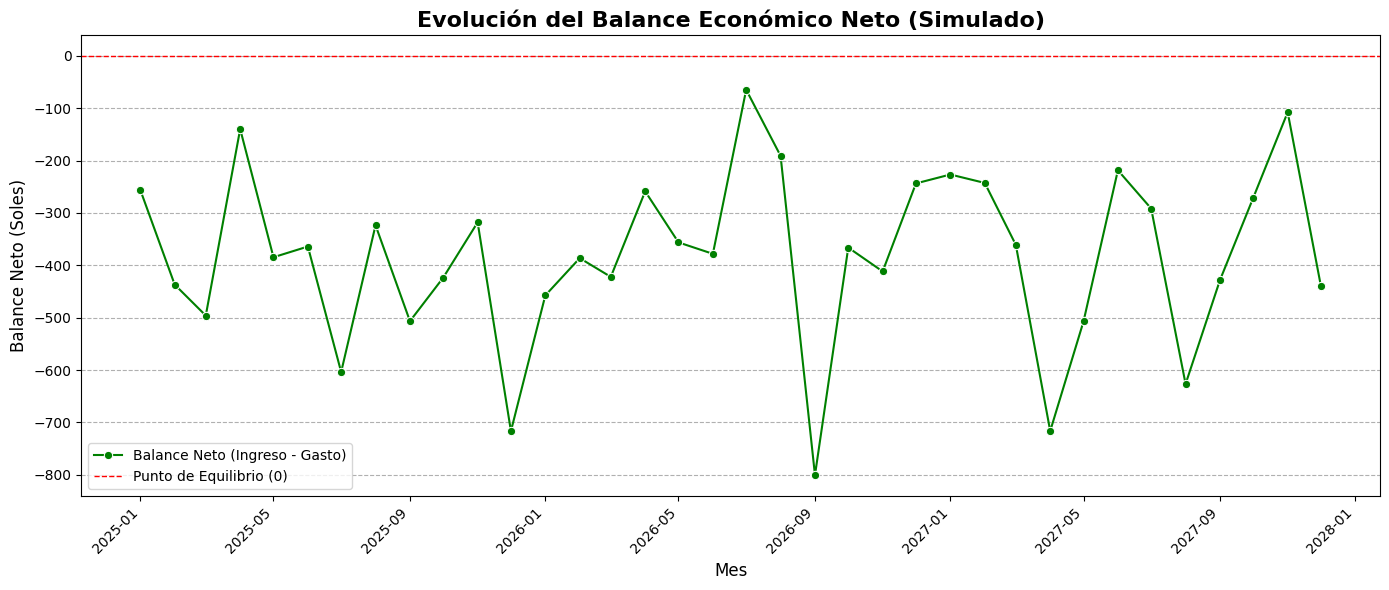

Se ha guardado la gráfica del balance en: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/balance_mensual_simulado.png

Promedio mensual de Balance Neto (Ahorro/Déficit) en el periodo simulado: S/ -381.72
Conclusión Preliminar: La simulación sugiere un déficit mensual promedio, indicando que el sueldo mínimo no cubre los gastos proyectados.


In [25]:
# =========================================================================
# 5. ANÁLISIS DEL BALANCE PROYECTADO (RMV vs. Gastos simulados)
# =========================================================================

print("\n--- Análisis del Balance Mensual (Ingresos vs. Gastos) ---")

# Calcular Ingresos y Gastos Mensuales
df_final_simulacion['Anio_Mes'] = df_final_simulacion['fecha'].dt.to_period('M')

# Agrupar transacciones por mes y tipo
df_balance = df_final_simulacion.groupby(['Anio_Mes', 'tipo'])['monto'].sum().unstack(fill_value=0).reset_index()

# Calcular el balance (Ahorro/Déficit)
df_balance['Balance_Neto'] = df_balance['ingreso'] - df_balance['gasto']

# Convertir Period a datetime para graficar
df_balance['Fecha_dt'] = df_balance['Anio_Mes'].dt.to_timestamp()

# Visualización del Balance Neto
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_balance, x='Fecha_dt', y='Balance_Neto', marker='o', color='green', label='Balance Neto (Ingreso - Gasto)')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Punto de Equilibrio (0)')

plt.title('Evolución del Balance Económico Neto (Simulado)', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Balance Neto (Soles)', fontsize=12)
plt.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

ruta_grafica_balance = os.path.join(os.getcwd(), 'balance_mensual_simulado.png')
plt.savefig(ruta_grafica_balance)
plt.show()

print(f"Se ha guardado la gráfica del balance en: {ruta_grafica_balance}")

# Resumen de Ahorro/Déficit promedio
ahorro_promedio = df_balance['Balance_Neto'].mean()
print(f"\nPromedio mensual de Balance Neto (Ahorro/Déficit) en el periodo simulado: S/ {ahorro_promedio:.2f}")

if ahorro_promedio > 0:
    print("Conclusión Preliminar: La simulación sugiere un pequeño margen de ahorro en promedio.")
else:
    print("Conclusión Preliminar: La simulación sugiere un déficit mensual promedio, indicando que el sueldo mínimo no cubre los gastos proyectados.")